<a href="https://www.kaggle.com/code/cocoyachi/text-classification-by-huggingface?scriptVersionId=114293302" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

* This notebook is for studying personally and I referred to other people's contents.

# 🤗Huggingface classic pipeline

#### 1. Dataset : load and preprocessing
#### 2. Tokenizer : input data tokenize
#### 3. Transformers : model load and train
#### 4. Evaluation

# Use datasets📖
* I will use "SetFit/emotion" dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datasets import list_datasets

all_datasets = list_datasets() # list type
print(f"Number of datasets : {len(all_datasets)}")
print(f"datasets example : {all_datasets[2323:2333]}") # you can change range of the list

Number of datasets : 10000
datasets example : ['lysandre/my-cool-dataset', 'm3hrdadfi/recipe_nlg_lite', 'mad/IndonesiaNewsDataset', 'maindadwitiya/weather_dataset', 'maji/npo_mission_statement_ucf', 'majod/CleanNaturalQuestionsDataset', 'makanan/umich', 'malay-huggingface/pembalakan', 'mammut/mammut-corpus-venezuela-test-set', 'mammut/mammut-corpus-venezuela']


In [3]:
from datasets import load_dataset

emotions = load_dataset("SetFit/emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/SetFit--emotion-ddb0f0516f8def09/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 16000
})

In [5]:
# Let's take a closer look.
print(f"train_ds length : {len(train_ds)}\n")
print(f"train_ds first data : {train_ds[0]}\n")
print(f"train_ds column names : {train_ds.column_names}\n")
print(f"emotion features : {train_ds.features}\n")

train_ds length : 16000

train_ds first data : {'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}

train_ds column names : ['text', 'label', 'label_text']

emotion features : {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'label_text': Value(dtype='string', id=None)}



In [6]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3], 'label_text': ['sadness', 'sadness', 'anger', 'love', 'anger']}


In [7]:
print(train_ds["text"][:3])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong']


#### Now the form of the data is not intuitive, so it will convert it to another form. <br>
#### Huggingface provides the ability to convert to a dataframe.

In [8]:
import pandas as pd

emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [9]:
df.sample(20)

,text,label,label_text
7138,i feel like it isnt totally resolved with angie,1,joy
4354,i was feeling productive,1,joy
3775,i feel for the guy because i think he is since...,1,joy
175,i specifically wanted tango was feeling shy an...,4,fear
3615,im feeling ugly lately,0,sadness
7670,im feeling homesick for him,0,sadness
7390,tutorial again a fearful feeling came to me wh...,4,fear
8159,i am not a catholic i certainly don t feel it ...,5,surprise
7766,i advanced boldly feeling most adventurous at ...,1,joy
5644,i alight in front of the hotel i can feel the ...,1,joy


# Class Distribution Check📊

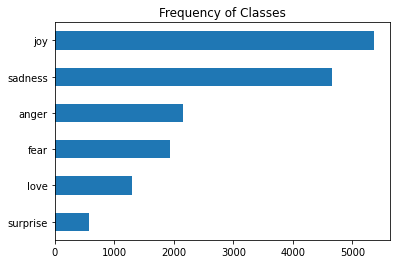

In [10]:
import matplotlib.pyplot as plt

df['label_text'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

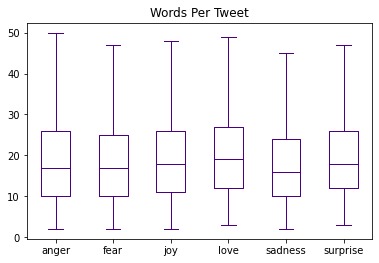

In [11]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_text", grid=False, showfliers=False, color='indigo')
plt.suptitle("")
plt.xlabel("")
plt.show()

* Tweet Length Average : around 15 words
* We don't neee DataFrame format reset and make train,test data

In [12]:
emotions.reset_format()

# Text to Token & Extract Hidden state

* Use AutoTokenizer from DistilBERT
* Use AutoModel

In [13]:
from transformers import AutoTokenizer

model_distil = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_distil)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [14]:
text = "Last Christmas I gave you my heart. But the very next day you gave it away"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 2197, 4234, 1045, 2435, 2017, 2026, 2540, 1012, 2021, 1996, 2200, 2279, 2154, 2017, 2435, 2009, 2185, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [15]:
def tokenize(batch):
    # padding : Padding to zero for the longest sample
    # truncation : Cut to fit the model's maximum context size
    return tokenizer(batch["text"], padding=True, truncation=True)

In [16]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [17]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [18]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'label_text', 'input_ids', 'attention_mask']


In [19]:
# Need to settings -> accelerator use gpu
import torch
from transformers import AutoModel

model_distil = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_distil).to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [21]:
emotions_encoded.set_format("torch",
                           columns = ['input_ids','attention_mask','label'])

In [22]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [23]:
emotions_hidden["train"].column_names

['text', 'label', 'label_text', 'input_ids', 'attention_mask', 'hidden_state']

In [24]:
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

# Train set Visualize
* use UMAP algorithm vector makes 2D

In [25]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X","Y"])
df_emb["label"] = y_train
df_emb.head()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,X,Y,label
0,4.464489,6.091126,0
1,-2.781078,5.420690,0
2,5.326754,2.515114,3
3,-2.111793,3.225602,2
4,-3.241518,3.477460,3


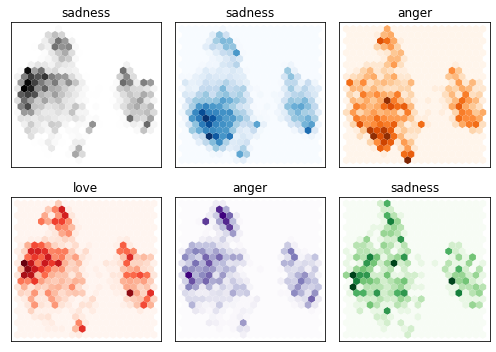

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"]["label_text"]

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

# Transformer fine-tuning

### 1. Load pre-trained model

In [27]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
        .from_pretrained(model_distil, num_labels = num_labels)
        .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

### 2. Define Metrics

In [28]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = "weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy":acc, "f1":f1}

### 3. Train Model
* you need huggingface token
* [token_help_page_click_here](https://huggingface.co/docs/hub/security#user-access-tokens)

In [29]:
from huggingface_hub import notebook_login

notebook_login()

In [30]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f'{model_distil}-finetuned-emotion'
training_args = TrainingArguments(output_dir=model_name,
                                num_train_epochs=2,
                                learning_rate=2e-5,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                weight_decay=0.01,
                                evaluation_strategy="epoch",
                                disable_tqdm=False,
                                logging_steps=logging_steps,
                                push_to_hub=False,
                                save_strategy="epoch",
                                load_best_model_at_end=True,
                                log_level="error"
                               )

* https://wandb.ai/ login and click the huggingface you can see api key

In [31]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer = tokenizer
                 )
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.842900,0.311897,0.906500,0.904187
2,0.244000,0.217206,0.929000,0.928918


TrainOutput(global_step=500, training_loss=0.54344287109375, metrics={'train_runtime': 165.5744, 'train_samples_per_second': 193.267, 'train_steps_per_second': 3.02, 'total_flos': 720342861696000.0, 'train_loss': 0.54344287109375, 'epoch': 2.0})

In [32]:
preds_output = trainer.predict(emotions_encoded['validation'])

In [33]:
preds_output.metrics

{'test_loss': 0.21720603108406067,
 'test_accuracy': 0.929,
 'test_f1': 0.9289179991508163,
 'test_runtime': 2.6966,
 'test_samples_per_second': 741.672,
 'test_steps_per_second': 11.867}

In [34]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [35]:
set(labels)

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

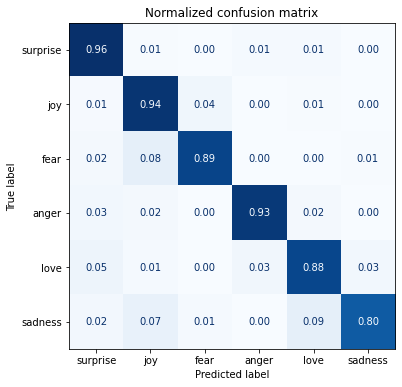

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(labels))
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

if you upload this model to huggingface hub, you must download git lfs
```python
trainer.push_to_hub(commit_message="Training completed!")

from transformers import pipeline

#  change MY_HUGGINGFACE_ID to your id 
model_id = "MY_HUGGINGFACE_ID/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)
```

I use others model

In [37]:
from transformers import pipeline

model_id = "haesun/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

2022-12-20 08:24:02.986429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 08:24:02.987567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 08:24:02.988230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 08:24:02.990154: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [38]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

In [39]:
preds

[{'label': 'LABEL_0', 'score': 0.010602043010294437},
 {'label': 'LABEL_1', 'score': 0.957961916923523},
 {'label': 'LABEL_2', 'score': 0.013847319409251213},
 {'label': 'LABEL_3', 'score': 0.006581718567758799},
 {'label': 'LABEL_4', 'score': 0.004631168209016323},
 {'label': 'LABEL_5', 'score': 0.006375874858349562}]

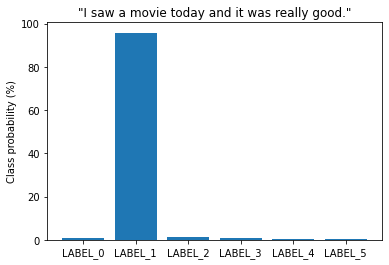

In [40]:
preds_df = pd.DataFrame(preds)
plt.bar(preds_df.label, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()